In [1]:
import numpy as np
import sympy
from sympy import *
from sympy import diff
from sympy import lambdify
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, rfft
from numpy.linalg import eig
import math
import pickle
import random
import numpy
from nodepy import rk, stability_function
from IPython.display import clear_output
from scipy.optimize import fsolve
from scipy.optimize import minimize

rk4 = rk.loadRKM('RK44').__num__()
ssp3 = rk.loadRKM('SSP33').__num__()
ssp2 = rk.loadRKM('SSP22').__num__()
bs5 = rk.loadRKM('BS5').__num__()

fehlberg45 = rk.loadRKM("Fehlberg45").__num__()


A22= np.array([[0,0],[0.5,0]])
b22= np.array([0,1])
rk2= rk.ExplicitRungeKuttaMethod(A22,b22)

A31= np.array([[0,0,0], [2/3,0,0], [1/3,1/3,0]])
b31= np.array([1/4, 0, 3/4])
rk31=  rk.ExplicitRungeKuttaMethod(A31,b31)


base_methods= [ssp2, rk31, rk4, bs5]

base_method_labels= ["SSPRK(2,2)","RK(3,3)", "RK(4,4)", "BSRK(8,5)"]



types= ["RK", "RRK", "RFRK"]

k= np.zeros((4,8))
k[0,:]= [1,-1,0,0,0,0,0,0]
k[1,:]= [2,-1,-1,0,0,0,0,0]
k[2,:]= [1,2,-2,-1,0,0,0,0]
k[3,:]= [2,-1,-1,0,0,0,0,0]



In [2]:
colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']
#linestyles = ['-', '--', '-.', ':', "-", "--", "-."]
linestyles = ['-', '--', '-.', ':', (5, (10, 3)),(0, (3, 1, 1, 1))]
markers = ['o','D','X','s','v',"P"]

In [3]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25}

import matplotlib
matplotlib.rc('font', **font)

#plt.rc("text", usetex=True)
plt.rc("legend", fontsize="medium", fancybox=True, framealpha=0.5)

plt.rcParams["mathtext.fontset"] = "cm"

In [4]:

def analytical_sol(t):
    w0= np.cos(t)
    w1= np.sin(t)

    return np.array([w0, w1])

def G_1(u):
    
    return 0.5*np.dot(u,u)

def dG_1(u):
    return u




def rgam(gamma,u,inc1,E1_old, est):
    gamma1 = gamma
    uprop = u + gamma1*inc1 
    E1 = G_1(uprop)

    return E1-E1_old - (gamma1+1)*est
    

def rgam_RF(eps,dt, u_tilde, search1, E1_old, est):
    
    
    uprop = u_tilde + dt* eps* search1 
    E1 = G_1(uprop)

    return E1-E1_old - est


def proj_distance(k_0, s, F, dt, u_tilde, E1_old, est):

    no_inv = 1; eps0 = 0.1
    
    
    k_01= k_0.copy()
    

    search_01= sum([k_01[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_01[i]*F[i,:] for i in range(s)]))

    eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, u_tilde,search_01,E1_old, est),full_output=True)
 

    distance= np.linalg.norm(dt*eps* search_01 )
  
    return distance

    

def Angle_between(k, s, F, V2):

    #print('k: ',k)
    
    V1= sum([k[i]*F[i] for i in range(s)])
    norm_V1= np.linalg.norm(V1)

    #print('|V1|: ',norm_V1 )
    V1= V1/ norm_V1


    
    norm_V2= np.linalg.norm(V2)
    #print('|V2|', norm_V2)
    
    V2= V2/ norm_V2

    inner_prod= np.dot(V1, V2)
    if inner_prod >= 1:  # numerical error may cause it be slightly bigger than 1 and angle becomes NaN
        inner_prod= 1

    
   

    deg= (180/np.pi)* np.arccos(inner_prod)

 

    return deg


In [5]:
def project_direction(u, F):
    s= np.size(F[:, 0])
    n= np.size(F[0, :])

    Normals= np.zeros((1, n))




    for i in range(s):
        normal = F[i , :].copy()
        for j in range(np.size( Normals[:, 0] )):

            normal -= np.dot(normal, Normals[j, :])* Normals[j, :]

        
        
        if np.linalg.norm(normal) > 1.e-7:
            normal= normal / np.linalg.norm(normal)

            Normals= np.append(Normals, np.reshape(normal.copy(), (1,len(normal))), axis=0)
            

    
    
 
    
    u_projected= np.zeros(n)
    for i in range(np.size( Normals[:, 0] )):
        #print('dot(u, Normals): ',np.dot(u, Normals[i, :]))
        u_projected += np.dot(u, Normals[i, :])* Normals[i, :]


    return u_projected

# Baseline RK

In [6]:
# Compute solution with baseline RK methods
def compute_sol_without_relaxation(Mthdname,rkm, dt, f, T, u0,t0): 
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    steps = 0
    
    while t < T and not np.isclose(t, T):
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
        inc = dt*sum([rkm.b[i]*F[i] for i in range(s)])    
        unew = uu[-1]+inc; t+= dt
        tt = np.append(tt, t)
        steps +=1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        #print("Method = Baseline %s: Step number = %d (time = %1.2f)"%(Mthdname,steps,tt[-1]))
    return tt, uu

# RRK

In [7]:
def compute_relaxation(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    
    Gamma = np.array([]); 
    proj_length= []
    
    no_inv = 1; gamma0 = 1
    Inv1_change= np.array([]); 

   
    
    errs = 0; steps = 0

    n=0 #test

    
    
    while t < T and not np.isclose(t, T):
    #while t < T and not n > 1:

        n+=1 #test
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])

        est= dt* sum(rkm.b[i]*np.dot(y[i], F[i]) for i in range(s) )
        print('est: ', est)
       
        
        wr_unew = uu[-1] + inc1; E1_old = G_1(uu[-1]) 
        
        gamma, info, ier, mesg = fsolve(rgam,gamma0,args=(wr_unew,inc1,E1_old, est),full_output=True)

       
        print('gamma: ',gamma)

        gamma1= gamma 
        

        
    
        
        

        numer = 2 * sum(rkm.b[i] * rkm.A[i, j] * np.dot(F[i], F[j]) \
                            for i in range(s) for j in range(s))
        
        denom = sum(rkm.b[i] * rkm.b[j] * np.dot(F[i], F[j]) for i in range(s) for j in range(s))

        #print('numer: ', numer)
        #print('denom: ', denom)

        gam = numer / denom -1
        #print('1+gam: ', 1+gam)

        gamma1= gam



      



        
        
        unew =  wr_unew + gamma1*inc1 ; t+=(1+gamma1)*dt

        proj_length= np.append(proj_length, np.linalg.norm(gamma1*inc1 ))
        E1_new= G_1(unew)
       
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        Gamma = np.append(Gamma, gamma1);

        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; 
        
        print("Method = Relaxation %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Gamma,  proj_length

# QO_RK

In [8]:
def compute_sol_QO(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    u = np.array(u0)
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    b= rkm.b

    k_0= b - np.ones(b.size)/b.size
    if not np.any(k_0):    # if all elements of k_0 are zero
        k_0[0] +=1
        k_0[1] += -1

        #k_01= k_0.copy()
    k_0= k_0/np.linalg.norm(k_0)
    k1= k_0
    
    
    Eps1 = np.array([]); 
    Inv1_change= np.array([]); 
    proj_length= []
    
    
    no_inv = 1; eps0 = 0
    
    errs = 0; steps = 0

    n=0 #test
    while t < T and not np.isclose(t, T):
    #while t < T and not n > 10:
        clear_output(wait=True)

        n+=1 #test
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = u.copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])

  


        
        u_tilde= u + dt*sum([b[i]*F[i] for i in range(s)])
        #print(u_tilde/np.linalg.norm(u_tilde))

        est= dt* sum(b[i]*np.dot(y[i], F[i]) for i in range(s) )
        #print('est: ', est)
        
        E1_old = G_1(u); 
        

        k_0 = k1

        dG_tilde= dG_1(u_tilde)

        search = project_direction (dG_tilde, F) # projects dG_1(wr_unew) to the space created by stage derivative vectors
        if np.linalg.norm(search) < 1.e-5:
            print('Search close to zero')

        search= search /np.linalg.norm(search)
      
  

        
        eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, u_tilde,search,E1_old, est),full_output=True)
        #print('ier: ', ier)
        
   
        #print('eps: ',eps)

 
        #C= np.dot(u_tilde, u_tilde) - np.dot(u,u)
        #B= np.dot(u_tilde, search1)
        #Delta= B**2 - C
        #Eps= -B + np.sqrt(Delta)

        #eps= Eps/dt
        

        
        u = u_tilde + dt*eps*search ; t+=dt
        #print('projection_length: ', np.linalg.norm(u-u_tilde))

        proj_length= np.append(proj_length, np.linalg.norm(dt*eps*search))
       
        


        E1_new= G_1(u)

        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(u.copy(), (1,len(u))), axis=0) 
        Eps1 = np.append(Eps1, eps); 
        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; 
        #print("Method = RF %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Eps1, proj_length

# Directional method

In [9]:
def compute_sol_D(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    u = np.array(u0)
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    b= rkm.b

    k_0= b - np.ones(b.size)/b.size
    if not np.any(k_0):    # if all elements of k_0 are zero
        k_0[0] +=1
        k_0[1] += -1

        #k_01= k_0.copy()
    k_0= k_0/np.linalg.norm(k_0)
    k1= k_0
    
    
    Eps1 = np.array([]); 
    Inv1_change= np.array([]); 
    proj_length= []
    
    
    no_inv = 1; eps0 = 0
    
    errs = 0; steps = 0

    n=0 #test
    while t < T and not np.isclose(t, T):
    #while t < T and not n > 10:
        clear_output(wait=True)

        n+=1 #test
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = u.copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])

  


        
        u_tilde= u + dt*sum([b[i]*F[i] for i in range(s)])
        #print(u_tilde/np.linalg.norm(u_tilde))

        est= dt* sum(b[i]*np.dot(y[i], F[i]) for i in range(s) )
        print('est: ', est)
        
        E1_old = G_1(u); 
        

        k_0 = k1

        dG_tilde= dG_1(u_tilde)

        #k_minimization= minimize(Angle_between, k_0, args=(s, F, dG_tilde), method='SLSQP',options={'maxiter':100},tol=1e-6)

        #k1= k_minimization.x
        #k1= k1/ np.linalg.norm(k1)

        #print('Angle_01: ', Angle_between(k1, s, F,  dG_tilde))
        

        #print('k: ', k1)
        

        search= sum([b[i]*F[i] for i in range(s)]) - F[0]

        search1= search/ np.linalg.norm(search) # For this problem they become equal
      
  

        
        eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, u_tilde,search1,E1_old, est),full_output=True)
        print('ier: ', ier)
        
   
        print('eps: ',eps)

        
        u = u_tilde + dt*eps*search1 ; t+=dt
        #print('projection_length: ', np.linalg.norm(u-u_tilde))

        proj_length= np.append(proj_length, np.linalg.norm(dt*eps*search1))

        
       
        


        E1_new= G_1(u)

        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(u.copy(), (1,len(u))), axis=0) 
        Eps1 = np.append(Eps1, eps); 
        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; 
        print("Method = RF %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Eps1, proj_length

# Nonlinear Oscillator

In [10]:
def f_Nonlin_osil(u):
    return 1/(np.dot(u,u))* np.array([-u[1], u[0]])

u0= np.array([1, 0])
t0=0

f= f_Nonlin_osil


# RK 

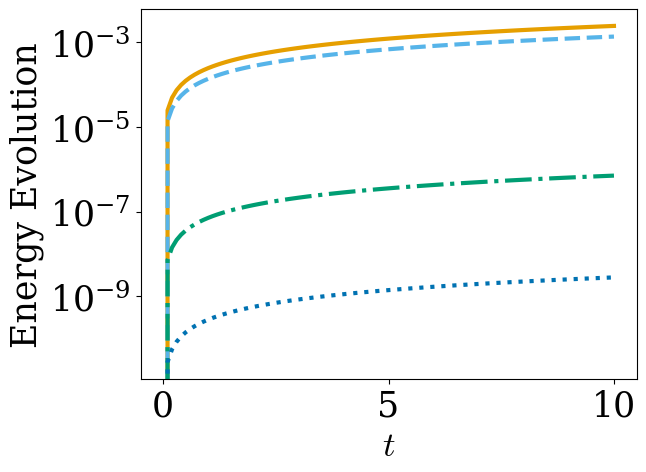

<Figure size 640x480 with 0 Axes>

In [11]:
u0= np.array([1, 0])

dt= 0.1
t_final= 10
t0=0

f= f_Nonlin_osil

for b,base in enumerate(base_methods):
    
    tt, uu=  compute_sol_without_relaxation('rk',base, dt, f, t_final, u0,t0)
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i,:], uu[i,:])
        
    plt.yscale("log")
    plt.plot(tt, np.abs(E-E[0]), color=colors[b], linestyle=linestyles[b] ,lw=3, label=base_method_labels[b])
    
plt.xlabel("$t$")
plt.ylabel("Energy Evolution")


#plt.savefig("Figures/Nonlin_oscil_evol_RK.png",bbox_inches="tight")


ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=4)
#plt.savefig("./Figures/Nonlin_oscil_evol_legend.png", bbox_inches="tight")



plt.show()  
        


# Relaxation RK

est:  4.2878352040555974e-19
gamma:  [-2.76965637e-09]
Method = Relaxation RK: At step number = 100 (time = 10.00), integer flag = 5 and E1-E1_old = 0.000000 



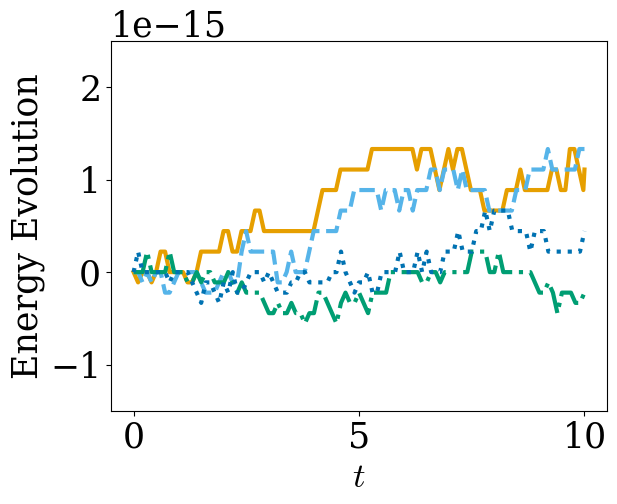

In [12]:

for b,base in enumerate(base_methods):
    
    tt, uu, Gamma,  Inv1_change=  compute_relaxation('RK',base, dt, f, t_final, u0, t0)
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i,:], uu[i,:])
        
    #plt.yscale("log")
    plt.plot(tt, E-E[0], color=colors[b] ,linestyle=linestyles[b] ,lw=3, label=base_method_labels[b])
    
plt.xlabel("$t$")
plt.ylabel("Energy Evolution")

plt.ylim([-1.5e-15,2.5e-15])


#plt.savefig("Figures/Nonlin_oscil_evol_RRK.png",bbox_inches="tight")

plt.show() 

# QO _ RK

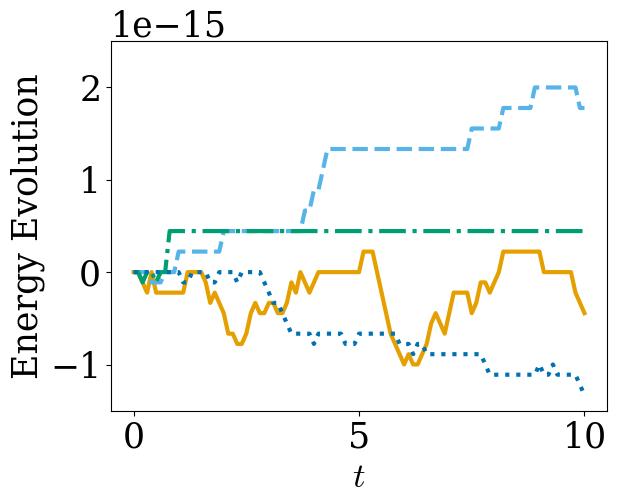

In [13]:
for b,base in enumerate(base_methods):
    
    tt, uu, Eps1, Inv1_change=   compute_sol_QO(base_method_labels[b],base, dt, f, t_final, u0, t0)
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i,:], uu[i,:])
        
    plt.plot(tt, E-E[0], color=colors[b] ,linestyle=linestyles[b] ,lw=3, label=base_method_labels[b])
    
plt.xlabel("$t$")
plt.ylabel("Energy Evolution")

plt.ylim([-1.5e-15,2.5e-15])


#plt.savefig("Figures/Nonlin_oscil_evol_QO.png",bbox_inches="tight")

plt.show() 

# Convergence plots

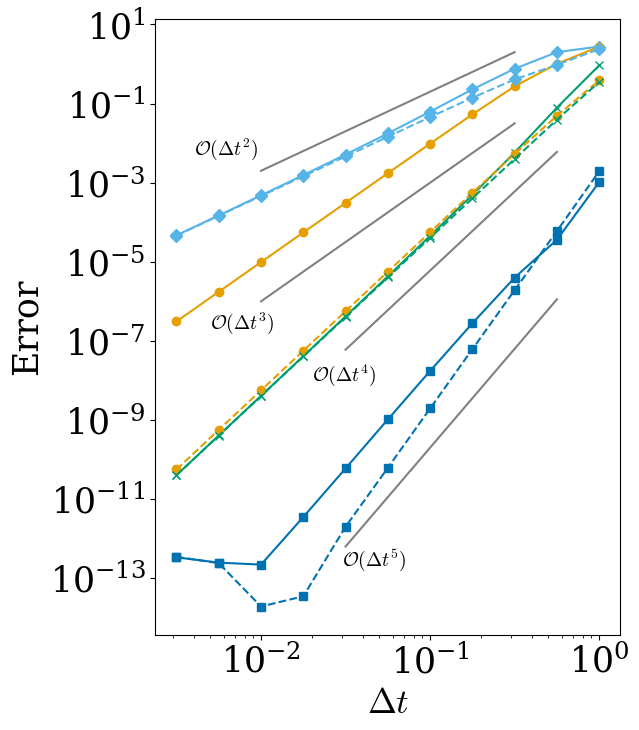

<Figure size 640x480 with 0 Axes>

In [14]:
base_methods= [ssp2, rk31, rk4, bs5]

markers = ['D','o','x','s','X',"P"]

colors = ['#56B4E9','#E69F00',  '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']


dts = np.logspace(-2.5,0.,11)

t_final=10

fig=plt.figure(figsize=(6,8))
ax = plt.subplot(111)
lines=[]

errors_b= np.zeros((len(base_methods), len(dts)))


#calculating the solutions
for b,base in enumerate(base_methods):
    sols_b= []
    for dt in dts:
        
        tt, uu=  compute_sol_without_relaxation(base_method_labels[b],base, dt, f, t_final, u0,t0)
        sols_b.append(uu[-1, :])

    
    ref = [np.cos(t_final), np.sin(t_final)]
    for i in range(len(sols_b)):
        errors_b[b, i]= np.sum(np.abs(ref - sols_b[i]))

    lines.append(plt.loglog(dts, errors_b[b], linestyle='-' ,color=colors[b],marker=markers[b], label=base_method_labels[b])[0])
    


#------------------------------------------------------------------------- 

errors_qo= np.zeros((len(base_methods), len(dts)))

for b,base in enumerate(base_methods):
    sols_qo= []
    for dt in dts:
        
        tt, uu, Eps1, Inv1_change=   compute_sol_QO(base_method_labels[b],base, dt, f, t_final, u0, t0)
     
        sols_qo.append(uu[-1, :])


    ref = [np.cos(t_final), np.sin(t_final)]
    for i in range(len(sols_qo)):
        errors_qo[b,i]= np.sum(np.abs(ref - sols_qo[i]))

    plt.loglog(dts, errors_qo[b], linestyle='--' ,color=colors[b],marker=markers[b])




plt.plot(dts[4:-1], 2.0e-5*dts[4:-1]**5,  color="gray")
plt.annotate(r"$\mathcal{O}(\Delta t^5)$", (3e-2, 2.0e-13), color="k", fontsize=14)

plt.plot(dts[4:-1], 6.0e-2*dts[4:-1]**4,  color="gray")
plt.annotate(r"$\mathcal{O}(\Delta t^4)$", (2e-2, 1.0e-8), color="k", fontsize=14)

plt.plot(dts[2:-2], 1*dts[2:-2]**3,  color="gray")
plt.annotate(r"$\mathcal{O}(\Delta t^3)$", (5e-3, 2e-7), color="k", fontsize=14)

plt.plot(dts[2:-2], 20*dts[2:-2]**2,  color="gray")
plt.annotate(r"$\mathcal{O}(\Delta t^2)$", (4e-3, 5e-3), color="k", fontsize=14)


        
            
plt.xlabel("$\Delta t$")
plt.ylabel("Error")




#plt.savefig("Figures/Nonlin_oscil_convergence.png",bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=4)
#plt.savefig("./Figures/Nonlin_oscil_converg_legend.png",bbox_inches="tight")


plt.show()  



# Projection lengths

est:  5.918954344977928e-22
gamma:  [-5.46756647e-09]
Method = Relaxation RK(4,4): At step number = 11 (time = 10.00), integer flag = 5 and E1-E1_old = 0.000000 



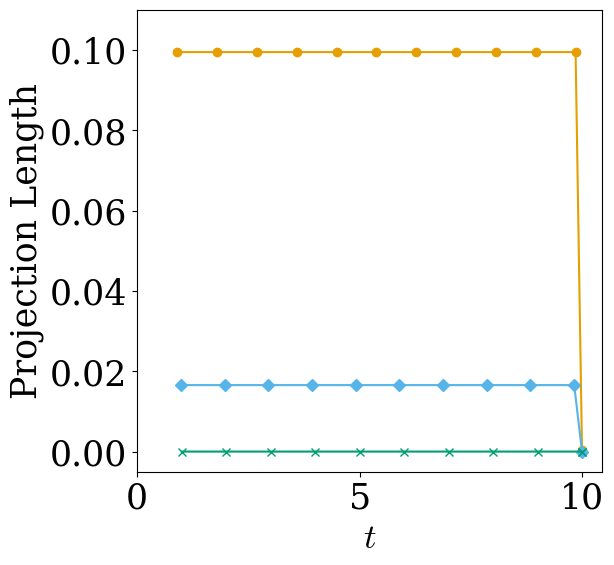

<Figure size 640x480 with 0 Axes>

In [15]:
#markers = ['o','D','X','s','v',"P"]
markers = ['o','D','x','s','v',"P"]
colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']


dts = np.logspace(-2.5,0.,11)

t_final=10

fig=plt.figure(figsize=(6,6))
ax = plt.subplot(111)
lines=[]

r_base_method_labels= ["RK(3,3)", "RK(4,4)", "BSRK(8,5)"]

rf_base_method_labels= ["RF_RK(3,3)", "RF_RK(4,4)", "RF_BSRK(8,5)"]

qo_base_method_labels= ["QO_RK(3,3)", "QO_RK(4,4)", "QO_BSRK(8,5)"]




for b,base in enumerate(base_methods[1:]):
    sols= []
    gamma_dt= []
    dt= 1
        
        
    tt, uu, Gamma,  proj_length=  compute_relaxation(base_method_labels[b],base, dt, f, t_final, u0, t0)

    plt.plot(tt[1:], proj_length[:],linestyle='-',color=colors[b],marker=markers[b], label=r_base_method_labels[b] )

    
    


plt.xlabel("$t$"); plt.ylabel("Projection Length")
#plt.xscale("log"); plt.yscale("log")

plt.ylim([-0.005,0.11])
plt.xticks([0, 5,10])

#plt.savefig("Figures/Nonlin_oscil_proj_length_RRK.png",bbox_inches="tight")


ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=4)
#plt.savefig("./Figures/Nonlin_oscil_proj_len_legend.png", bbox_inches="tight")



plt.show()

est:  -1.6010571497485975e-17
ier:  1
eps:  [9.1053381e-06]
Method = RF RK(4,4): At step number = 10 (time = 10.00), integer flag = 1 and E1-E1_old = 0.000000 



([<matplotlib.axis.XTick at 0x7612441b84c0>,
 [Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10')])

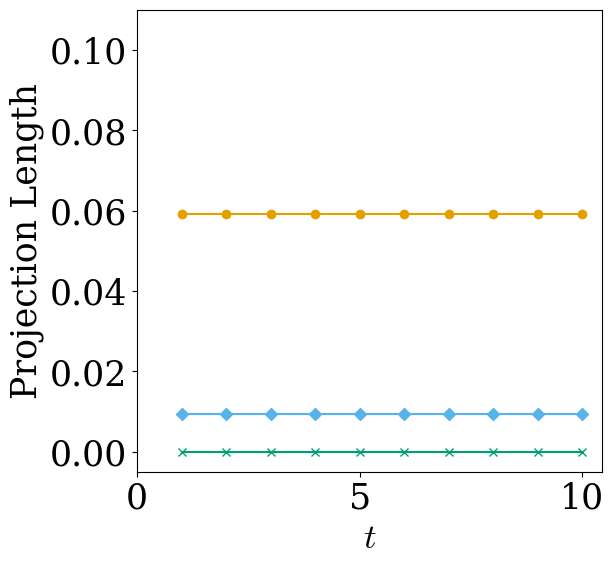

In [16]:
dts = np.logspace(-2.5,0.,11)

t_final=10

fig=plt.figure(figsize=(6,6))
ax = plt.subplot(111)
lines=[]

r_base_method_labels= ["R_RK(3,3)", "R_RK(4,4)", "R_BSRK(8,5)"]

rf_base_method_labels= ["RF_RK(3,3)", "RF_RK(4,4)", "RF_BSRK(8,5)"]

qo_base_method_labels= ["QO_RK(3,3)", "QO_RK(4,4)", "QO_BSRK(8,5)"]




for b,base in enumerate(base_methods[1:]):
    sols= []
    gamma_dt= []
    dt= 1
        
    

    
    tt, uu, Eps1, proj_length=   compute_sol_D(base_method_labels[b],base, dt, f, t_final, u0, t0)
    

    plt.plot(tt[1:], proj_length[:],linestyle='-',color=colors[b],marker=markers[b], label=rf_base_method_labels[b] )



plt.xlabel("$t$"); plt.ylabel("Projection Length")
#plt.xscale("log"); plt.yscale("log")

plt.ylim([-0.005,0.11])
plt.xticks([0, 5,10])


#plt.savefig("Figures/Nonlin_oscil_proj_length_RFRK.png",bbox_inches="tight")


([<matplotlib.axis.XTick at 0x7612440006d0>,
 [Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10')])

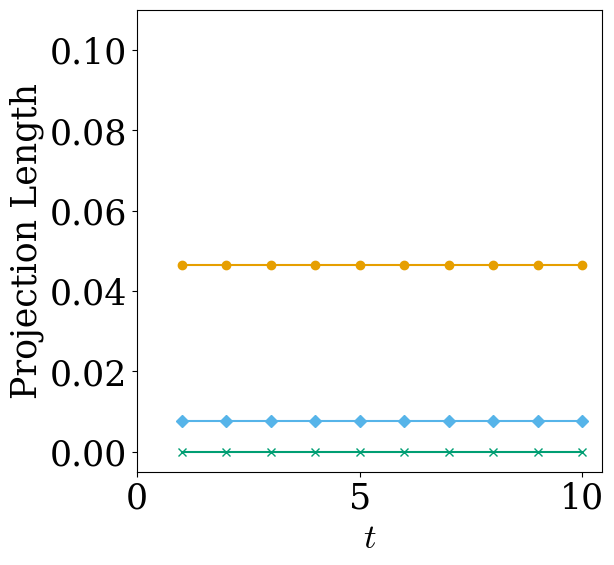

In [17]:
dts = np.logspace(-2.5,0.,11)

t_final=10

fig=plt.figure(figsize=(6,6))
ax = plt.subplot(111)
lines=[]

r_base_method_labels= ["R_RK(3,3)", "R_RK(4,4)", "R_BSRK(8,5)"]

rf_base_method_labels= ["RF_RK(3,3)", "RF_RK(4,4)", "RF_BSRK(8,5)"]

qo_base_method_labels= ["QO_RK(3,3)", "QO_RK(4,4)", "QO_BSRK(8,5)"]




for b,base in enumerate(base_methods[1:]):
    sols= []
    gamma_dt= []
    dt= 1
        
  


    tt, uu, Eps1, proj_length=   compute_sol_QO(base_method_labels[b],base, dt, f, t_final, u0, t0)
    
    plt.plot(tt[1:], proj_length[:],linestyle='-',color=colors[b],marker=markers[b], label=qo_base_method_labels[b] )


plt.xlabel("$t$"); plt.ylabel("Projection Length")


plt.ylim([-0.005,0.11])
plt.xticks([0, 5,10])


#plt.savefig("Figures/Nonlin_oscil_proj_length_QORK.png",bbox_inches="tight")
